In [92]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [94]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [97]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func

In [99]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [101]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)


/var/folders/qx/zjy9jsyd2sg69nyf65kyxhyr0000gn/T/ipykernel_22530/2035105942.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [103]:
# View all of the classes that automap found
table_names = list(Base.classes.keys())
print(table_names)

['station', 'measurement']


In [105]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [107]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [346]:
# Find the most recent date in the data set.

most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(most_recent)

('2017-08-23',)


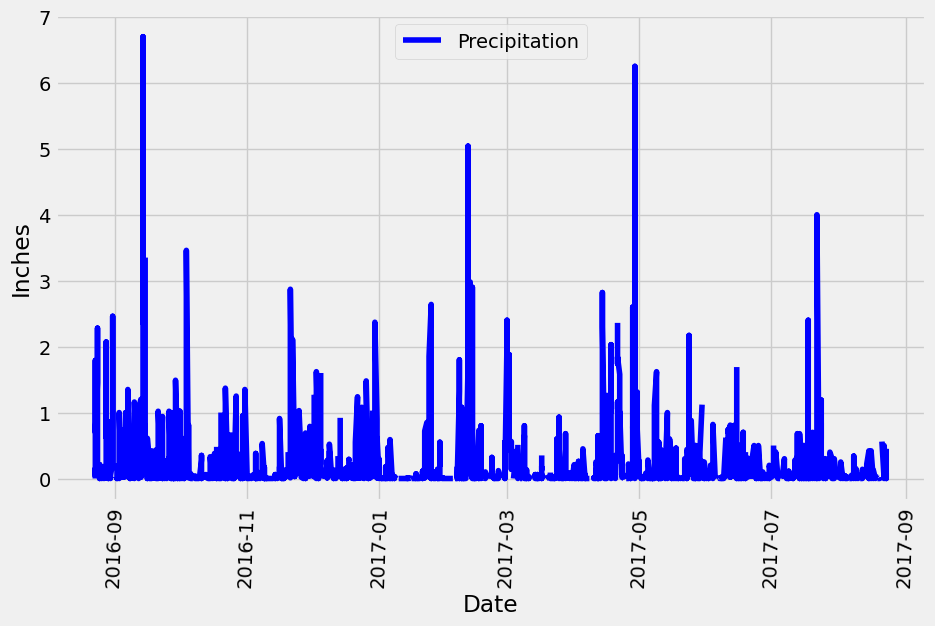

In [348]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent = dt.datetime.strptime(most_recent[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.

one_year_ago = most_recent - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

last_12_months_data = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= one_year_ago.strftime('%Y-%m-%d')
).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_12_months_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])  # Convert the date column to datetime format
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation', color='b')


plt.xlabel('Date')
plt.ylabel('Inches')

plt.xticks(rotation=88)

plt.legend(loc='upper center')

plt.show()

session.close()

In [273]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df['Precipitation'].describe()

precipitation_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [372]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()

total_stations


[(9,)]

In [388]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

session.query(Station.station, func.count(Measurement.station)) \
    .join(Measurement, Measurement.station == Station.station) \
    .group_by(Station.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()




[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [382]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# most_active_stations = session.query(Station.station, func.count(Measurement.station)) \
#     .join(Measurement, Measurement.station == Station.station) \
#     .group_by(Station.station) \
#     .order_by(func.count(Measurement.station).desc()) \
#     .first()  

# most_active_station = most_active_stations[0] 


# temperature_stats = session.query(func.avg(Measurement.tobs)  
# ).filter(Measurement.station == most_active_station).all()


# min_temp, max_temp, avg_temp = temperature_stats[0]


# result = [(min_temp, max_temp, avg_temp)]

# print(result)

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

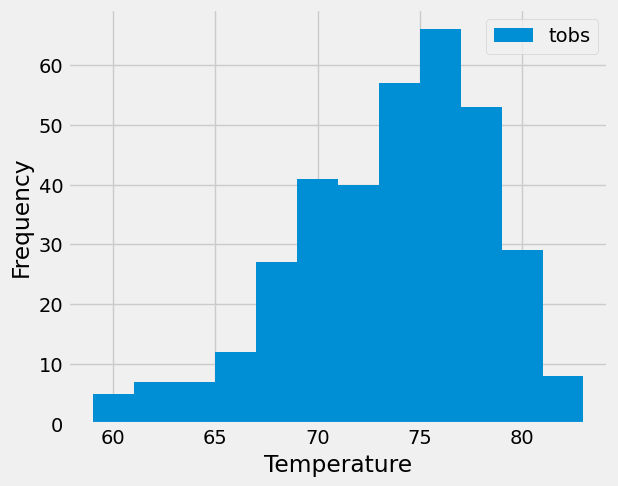

In [397]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")
plt.show()

# Close Session

In [400]:
# Close Session
session.close()